In [458]:
import momepy
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from libpysal.weights import Queen, Rook, KNN
%matplotlib inline

In [459]:
parcels = gpd.read_file('parcels_wdev2.shp')

In [460]:
parcels = parcels.reset_index()[['index', 'geometry']]
parcels = parcels.rename(columns={'index': 'ID'})
parcels.to_file('parcels_wdev2.shp')

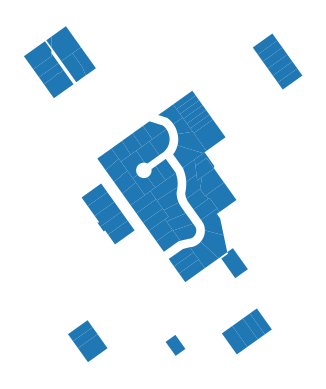

In [461]:
ax = parcels.plot()
ax.set_axis_off()

In [462]:
crs = parcels.estimate_utm_crs().to_epsg()
parcels = parcels.to_crs(crs)

In [463]:
def build_tessellation(df, unique_id, limit):
    limit = momepy.buffered_limit(df, buffer=limit)
    tessellation = momepy.Tessellation(df, unique_id=unique_id, limit=limit)
    tessellation_gdf = tessellation.tessellation
    #tessellation_gdf = tessellation_gdf.reset_index(drop=True)
    #tessellation_gdf['ID'] = tessellation_gdf.index

    return tessellation_gdf

In [464]:
og_tess = build_tessellation(parcels, 'ID', 1)
og_tess.to_file('og_tess.shp')

Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


In [465]:
def build_spatial_topology(df, contiguity, unique_id):
    if contiguity == 'rook':
        w = Rook.from_dataframe(df)
    elif contiguity == 'queen':
        w = Queen.from_dataframe(df)
    else:
        raise ValueError('Unknown contiguity type')

    return w

def get_components(df, w):
    # get component labels
    components = w.component_labels
    combined_polygons = df.dissolve(by=components)
    return combined_polygons

In [466]:
w_rook = build_spatial_topology(og_tess, 'rook', 'ID')

d:\mini-forge\envs\growth_model\Lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There is 1 island with id: 0.
  warnings.warn(message)


In [467]:
combine = get_components(og_tess, w_rook)


In [468]:
def get_distance(df, dist_band):
    for poly in range(len(df)):
        ID = df.iloc[poly].ID
        # Calcualtes distance for each point from each df. If Point resides along edge of df( within 1-meter), distance is is given NUll then dropped
        df[f'd_to_{ID}'] = (df.apply(lambda x: 
                                                df.iloc[poly].geometry.distance(x['geometry']) 
                                                if df.iloc[poly].geometry.distance(x['geometry']) < dist_band 
                                                else 0, axis=1)
                                                )
    
    return df

In [469]:
combine = get_distance(combine, dist_band=15.0)

In [470]:
combine

,geometry,ID,d_to_36,d_to_18,d_to_30,d_to_45,d_to_34,d_to_37,d_to_22,d_to_48,d_to_41
0,"POLYGON ((481635.059 4399502.366, 481635.020 4...",36,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
1,"POLYGON ((481669.145 4399644.884, 481634.474 4...",18,0.0,0.000000,12.955754,0.0,0.0,0.0,0.000000,0.0,0.000000
2,"POLYGON ((481555.293 4399729.957, 481550.856 4...",30,0.0,12.955754,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
3,"POLYGON ((481479.409 4399529.315, 481479.412 4...",45,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
4,"POLYGON ((481535.150 4399727.063, 481536.174 4...",34,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
5,"POLYGON ((481744.381 4399505.419, 481744.381 4...",37,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
6,"POLYGON ((481423.468 4399990.705, 481427.908 4...",22,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.984371
7,"POLYGON ((481837.701 4399993.591, 481842.055 4...",48,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
8,"POLYGON ((481454.322 4400031.363, 481458.760 4...",41,0.0,0.000000,0.000000,0.0,0.0,0.0,0.984371,0.0,0.000000


In [471]:
def identify_nearby_enclosures(df):
    cols = df.filter(regex='d_to_')
    df['nearby_enclosures'] = df[cols.columns.to_list()].sum(axis=1)
    return df

In [472]:
combine = identify_nearby_enclosures(combine)
combine

,geometry,ID,d_to_36,d_to_18,d_to_30,d_to_45,d_to_34,d_to_37,d_to_22,d_to_48,d_to_41,nearby_enclosures
0,"POLYGON ((481635.059 4399502.366, 481635.020 4...",36,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
1,"POLYGON ((481669.145 4399644.884, 481634.474 4...",18,0.0,0.000000,12.955754,0.0,0.0,0.0,0.000000,0.0,0.000000,12.955754
2,"POLYGON ((481555.293 4399729.957, 481550.856 4...",30,0.0,12.955754,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,12.955754
3,"POLYGON ((481479.409 4399529.315, 481479.412 4...",45,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
4,"POLYGON ((481535.150 4399727.063, 481536.174 4...",34,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
5,"POLYGON ((481744.381 4399505.419, 481744.381 4...",37,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
6,"POLYGON ((481423.468 4399990.705, 481427.908 4...",22,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.984371,0.984371
7,"POLYGON ((481837.701 4399993.591, 481842.055 4...",48,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
8,"POLYGON ((481454.322 4400031.363, 481458.760 4...",41,0.0,0.000000,0.000000,0.0,0.0,0.0,0.984371,0.0,0.000000,0.984371


In [473]:
def get_adj_id(x):
    ids = []
    x = dict(x.filter(regex='d_to_'))
    for col, row in x.items():
        if row != 0:
            ids.append(col.split('_')[-1]) 
    
    return ids


In [474]:
combine['adjacent_ID'] = combine.apply(lambda x: get_adj_id(x), axis=1)

In [475]:
combine[['ID', 'geometry']].to_file('combine.shp')

In [476]:
merge = combine[combine['nearby_enclosures'] != 0]
merge

,geometry,ID,d_to_36,d_to_18,d_to_30,d_to_45,d_to_34,d_to_37,d_to_22,d_to_48,d_to_41,nearby_enclosures,adjacent_ID
1,"POLYGON ((481669.145 4399644.884, 481634.474 4...",18,0.0,0.000000,12.955754,0.0,0.0,0.0,0.000000,0.0,0.000000,12.955754,[30]
2,"POLYGON ((481555.293 4399729.957, 481550.856 4...",30,0.0,12.955754,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,12.955754,[18]
6,"POLYGON ((481423.468 4399990.705, 481427.908 4...",22,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.984371,0.984371,[41]
8,"POLYGON ((481454.322 4400031.363, 481458.760 4...",41,0.0,0.000000,0.000000,0.0,0.0,0.0,0.984371,0.0,0.000000,0.984371,[22]


In [477]:
merge['limit'] = merge.apply(lambda x: x[f'd_to_{x.adjacent_ID[0]}'], axis=1)
merge = merge[['ID', 'limit', 'adjacent_ID', 'geometry']]

d:\mini-forge\envs\growth_model\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [478]:
remove_ids = merge.ID.to_list()
remove_ids

[18, 30, 22, 41]

In [479]:
remove_ids = []
tessellations = gpd.GeoDataFrame()
for index, row in merge.iterrows():
    ID = row.ID
    adjacent_ID = row.adjacent_ID[0]
    limit = row.limit
    geometry = row.geometry
    adj_geometry = merge[merge['ID'] == int(adjacent_ID)].geometry.values[0]
    df = gpd.GeoDataFrame(geometry=[geometry, adj_geometry], crs=merge.crs.to_epsg())
    df['ID'] = df.index

    tess = build_tessellation(df, 'ID', limit)
    w = build_spatial_topology(tess, 'rook', 'ID')
    combine = get_components(tess, w)

    sel_parcels = parcels.sjoin(combine, how='inner', op='intersects')
    sel_parcels = sel_parcels[['ID_left', 'geometry']].rename(columns={'ID_left': 'ID'})
    remove_ids.append(sel_parcels.ID.to_list())
    sel_tess = build_tessellation(sel_parcels, 'ID', (limit + 5))
    sel_w = build_spatial_topology(sel_tess, 'rook', 'ID')
    
    tessellations = pd.concat([tessellations, sel_tess], ignore_index=True)


    
    
    
    



    

Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


d:\mini-forge\envs\growth_model\Lib\site-packages\IPython\core\interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...
Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


d:\mini-forge\envs\growth_model\Lib\site-packages\IPython\core\interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...
Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


d:\mini-forge\envs\growth_model\Lib\site-packages\IPython\core\interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...
Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


d:\mini-forge\envs\growth_model\Lib\site-packages\IPython\core\interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


In [480]:
tessellations_clean = tessellations.drop_duplicates()


In [481]:
tessellations_clean.to_file('tessellations_clean.shp')

In [482]:
remove_ids = [item for sublist in remove_ids for item in sublist]
remove_ids = list(set(remove_ids))

In [484]:
og_tess = og_tess[~og_tess['ID'].isin(remove_ids)]
all_tess = pd.concat([og_tess, tessellations_clean], ignore_index=True)
all_tess.to_file('all_tess.shp')

In [486]:
w_rook_final = build_spatial_topology(all_tess, 'rook', 'ID')

d:\mini-forge\envs\growth_model\Lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There is 1 island with id: 0.
  warnings.warn(message)


In [488]:
all_ids = w_rook_final.id_order
islands = w_rook_final.islands
# remove islands from the list of all ids
all_ids = [x for x in all_ids if x not in islands]

In [490]:
for i in all_ids:
    print(f'ID: {i}: {w_rook_final.neighbors[i]}')

ID: 1: [2]
ID: 2: [1, 3]
ID: 3: [2]
ID: 4: [5]
ID: 5: [4, 6]
ID: 6: [5, 7]
ID: 7: [8, 6]
ID: 8: [7]
ID: 9: [10]
ID: 10: [9, 11]
ID: 11: [10, 12]
ID: 12: [11]
ID: 13: [14]
ID: 14: [13, 15]
ID: 15: [16, 14]
ID: 16: [17, 15]
ID: 17: [16, 18]
ID: 18: [17]
ID: 19: [20, 30]
ID: 20: [19, 21, 30]
ID: 21: [20, 30, 22, 39]
ID: 22: [40, 39, 21, 23]
ID: 23: [24, 41, 40, 22]
ID: 24: [25, 43, 41, 23]
ID: 25: [24, 26, 43, 45]
ID: 26: [25, 27, 45, 46]
ID: 27: [26, 28, 46]
ID: 28: [56, 50, 27, 46]
ID: 29: [30, 31]
ID: 30: [19, 20, 21, 39, 29, 31]
ID: 31: [32, 29, 30, 39]
ID: 32: [33, 34, 31, 39]
ID: 33: [32, 34, 39, 40, 42]
ID: 34: [32, 33, 42, 35]
ID: 35: [34, 36, 37, 42, 44]
ID: 36: [48, 35, 44, 37]
ID: 37: [48, 51, 35, 36, 53, 38]
ID: 38: [37, 53, 63]
ID: 39: [32, 33, 21, 22, 40, 30, 31]
ID: 40: [33, 39, 22, 23, 41, 42]
ID: 41: [23, 40, 24, 42, 43]
ID: 42: [33, 34, 35, 40, 41, 43, 44]
ID: 43: [24, 25, 42, 44, 45, 41]
ID: 44: [48, 35, 36, 42, 43, 45]
ID: 45: [43, 44, 46, 47, 48, 49, 25, 26]
ID: 46: [